# 1. Flight Network Analysis (Q1)

In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

Before make the graph we have to find out if the graph is directed or undirected. So we are going to analyze how many routes are reciprocal (have both directions) and calculate the percentage. Let's set the threshold at 70%. So if reciprocity is >= 70% we will treat our graph as undirected. If not, we will treat our graph as directed.

In [2]:
def check_reciprocity_in_dataset(data):
    # Group data to ensure unique routes
    unique_routes = data[['Origin_airport', 'Destination_airport']].drop_duplicates()

    # Create a set of routes and reverse routes
    routes = set(tuple(x) for x in unique_routes.to_numpy())
    reverse_routes = set((dest, origin) for origin, dest in routes)

    # Count reciprocal routes
    reciprocal_routes = routes.intersection(reverse_routes)
    reciprocity = len(reciprocal_routes) / len(routes) if len(routes) > 0 else 0

    print(f"Total Routes: {len(routes)}")
    print(f"Reciprocal Routes: {len(reciprocal_routes)}")
    print(f"Reciprocity: {reciprocity:.2%}")

In [3]:
data = pd.read_csv(r"C:\Users\nefel\Documents\GitHub\ADM_HW05\Airports2.csv")
check_reciprocity_in_dataset(data)

Total Routes: 36719
Reciprocal Routes: 27188
Reciprocity: 74.04%


## Missing Values

In [4]:
# Checking for missing values
missing_values = data.isna().sum()
print(missing_values)

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64


As we can see there are a lot of missing values when it comes to the coordinates of the airports. So we have to fill them.

In [15]:
unique_airports = pd.concat([data['Origin_airport'], data['Destination_airport']]).unique()
print(f"Unique airports to process: {len(unique_airports)}")

Unique airports to process: 727


We are going to use the <strong> geopy </strong> library in order to find the coordainates of the airports 

In [18]:
# Initialize the geolocator
geolocator = Nominatim(user_agent="flight_network_analysis", timeout=10)

# Define a function to fetch coordinates
def fetch_coordinates(airport_code, retries=3):
    """
    Fetches the latitude and longitude for a given airport code.
    Retries in case of timeout.
    """
    for attempt in range(retries):
        try:
            location = geolocator.geocode(f"{airport_code} airport")
            if location:
                return location.latitude, location.longitude
        except GeocoderTimedOut:
            print(f"Retrying for {airport_code}... (Attempt {attempt + 1})")
            time.sleep(1)  # Delay before retry
    return None, None  # If all retries fail

In [19]:
# Create a DataFrame to store airport coordinates
airport_coordinates = pd.DataFrame(unique_airports, columns=['Airport'])
airport_coordinates['Latitude'] = None
airport_coordinates['Longitude'] = None

In [20]:
# Fetch coordinates for all unique airports
for idx, airport in airport_coordinates.iterrows():
    lat, long = fetch_coordinates(airport['Airport'])
    airport_coordinates.at[idx, 'Latitude'] = lat
    airport_coordinates.at[idx, 'Longitude'] = long

In [21]:
# Create mapping dictionaries
lat_mapping = dict(zip(airport_coordinates['Airport'], airport_coordinates['Latitude']))
long_mapping = dict(zip(airport_coordinates['Airport'], airport_coordinates['Longitude']))

In [22]:
# Fill missing values
data['Org_airport_lat'] = data['Org_airport_lat'].fillna(data['Origin_airport'].map(lat_mapping))
data['Org_airport_long'] = data['Org_airport_long'].fillna(data['Origin_airport'].map(long_mapping))
data['Dest_airport_lat'] = data['Dest_airport_lat'].fillna(data['Destination_airport'].map(lat_mapping))
data['Dest_airport_long'] = data['Dest_airport_long'].fillna(data['Destination_airport'].map(long_mapping))

In [23]:
# Checking for any other missinf values
print(data[['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long']].isna().sum())

Org_airport_lat      1163
Org_airport_long     1163
Dest_airport_lat     1147
Dest_airport_long    1147
dtype: int64


After an other check we can see that the missing values have decreased but we still have some. For these airports we will create a manual dictionary which will have the lat and the long for each airport of the missing values.

In [24]:
# Identify missing origin airport codes
missing_origin_airports = data.loc[data['Org_airport_lat'].isna(), 'Origin_airport'].unique()
print(f"Missing Origin Airports: {missing_origin_airports}")

# Identify missing destination airport codes
missing_dest_airports = data.loc[data['Dest_airport_lat'].isna(), 'Destination_airport'].unique()
print(f"Missing Destination Airports: {missing_dest_airports}")

Missing Origin Airports: ['DQF' 'KY5' 'HIK' 'ESF' 'VWL' 'XXW' 'FVS' 'HLM' 'JSE' 'TN6' 'AIY' 'JRA'
 'JRB' 'TSS' 'WQM' 'KY1' 'IN1' 'TN3' 'OH5' 'KY3' 'OH3' 'VWT' 'WV1' 'OH2'
 'VWH' 'MI2' 'VWD' 'NY3' 'LSD' 'DQU' 'LWF' 'JZU' 'STF' 'TX6' 'OH1' 'DQC'
 'CGX']
Missing Destination Airports: ['IN1' 'TX6' 'JSE' 'AWX' 'VWL' 'CGX' 'VWD' 'HLM' 'MI2' 'LJY' 'VWH' 'NY3'
 'DQF' 'FVS' 'KY1' 'HIK' 'TSS' 'JRA' 'JRB' 'UXJ' 'XWL' 'TN6' 'ZXX' 'DQU'
 'XXW' 'TN3' 'LSD' 'NZJ' 'ESF' 'WV1' 'OH5' 'STF' 'OH3' 'WQM' 'LWF' 'KY5'
 'AIY' 'JCC' 'KY3' 'OH1']


In [29]:
manual_airport_coordinates = {
    'DQF' : (32.897480, -97.040443),  
    'KY5' : (37.5355556, -84.4072222),
    'HIK' : (21.32583333, -157.92166666),
    'ESF' : (31.395, -92.29583),
    'VWL' : (47.37611111, -94.79805555),
    'XXW' : (30.18055555, -82.57972222),
    'FVS' : (43.83388888,  -111.805),
    'HLM' : (42.79583, -86.16194),
    'JSE' : (58.30166666, -134.42444444),
    'TN6' : (35.99861111, -89.40611111),
    'AIY' : (39.3577777778, -74.46),
    'JRA' : (40.754626, -74.006808),
    'JRB' : (40.701116, -74.008801),
    'TSS' : (40.7425, -73.97194),
    'WQM' : (30.2125, -93.14333333),
    'KY1' : (37.56861111, -84.77222222),
    'IN1' : (41.30694444, -85.06416666),
    'TN3' : (35.50694444, -86.80361111),
    'OH5' : (39.24666666, -84.38888888),
    'KY3' : (38.058056, -83.979444),
    'OH3' : (39.44027777, -83.02305555),
    'VWT' : (32.11166666, -84.18833333),
    'WV1' : (38.29444444, -81.56555555),
    'OH2' : (40.3722222222, -83.8188888889),
    'VWH' : (31.9208333333, -102.3894444444),
    'MI2' : (42.74305555, -86.105),
    'VWD' : (36.31888888, -119.62972222),
    'NY3' : (42.45, -75.01638888),
    'LSD' : (38.09111111, -84.31666666),
    'DQU' : (55.77888888, -131.60138888),
    'LWF' : (35.23416666, -87.25805555),
    'JZU' : (42.89138888, -73.24638888),
    'STF' : (33.433056, -88.848611),
    'TX6' : (35.22202, -101.831642),
    'OH1' : (39.57027777, -83.42055555),
    'DQC' : (27.81277777, -80.49555555),
    'CGX' : (41.86, -87.6086111111),
    'AWX' : (32.32944444, -102.53027777),
    'UXJ' : (37.63138888, -84.33249999),
    'XWL' : (43.2125, -112.34583333),
    'ZXX' : (46.21833333, -119.20944444),
    'NZJ' : (33.67611, -117.73111),
    'JCC' : (37.8, -122.46666666),
    'LJY' : (37.64444444, -92.6525),
}

In [30]:
# Fill missing origin coordinates using the manual dictionary 
data['Org_airport_lat'] = data['Org_airport_lat'].fillna(
    data['Origin_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[0])
)
data['Org_airport_long'] = data['Org_airport_long'].fillna(
    data['Origin_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[1])
)

# Fill missing destination coordinates using the manual dictionary 
data['Dest_airport_lat'] = data['Dest_airport_lat'].fillna(
    data['Destination_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[0])
)
data['Dest_airport_long'] = data['Dest_airport_long'].fillna(
    data['Destination_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[1])
)

Doing the last check after applying our manual dictionary.

In [31]:
# Checking for any other missinf values
print(data[['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long']].isna().sum())

Org_airport_lat      0
Org_airport_long     0
Dest_airport_lat     0
Dest_airport_long    0
dtype: int64


Now we are ready to make our graph.

According to the analysis we did at the beginning our graph will be a undirected one.

In [33]:
 # Create an undirected graph
flight_network = nx.Graph()
    
    # Add edges from the dataset
for _, row in data.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    flight_network.add_edge(origin, destination)

## 1.2 Implement a function <strong> analyze_graph_features(flight_network) </strong>

In [34]:
def analyze_graph_features(flight_network):
    # 1. Count the number of airports (nodes) and flights (edges)
    num_nodes = flight_network.number_of_nodes()
    num_edges = flight_network.number_of_edges()

    print(f"Number of airports (nodes): {num_nodes}")
    print(f"Number of flights (edges): {num_edges}")

    # 2. Compute the density of the graph
    density = (2 * num_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
    print(f"Graph density: {density:.4f}")

    # 3. Compute degree for each airport
    degrees = dict(flight_network.degree())  # Dictionary {node: degree}

    # Plot histogram for degree distribution
    plt.figure(figsize=(8, 6))
    plt.hist(degrees.values(), bins=20, color='r', edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # 4. Identify hubs (airports with degree higher than the 90th percentile)
    degree_values = list(degrees.values())
    degree_90th_percentile = np.percentile(degree_values, 90)
    hubs = [node for node, degree in degrees.items() if degree > degree_90th_percentile]

    print(f"Hubs (airports with degree > 90th percentile): {hubs}")

    # 5. Determine if the graph is sparse or dense
    if density < 0.5:
        print("The graph is sparse.")
    else:
        print("The graph is dense.")


Number of airports (nodes): 727
Number of flights (edges): 23260
Graph density: 0.0881


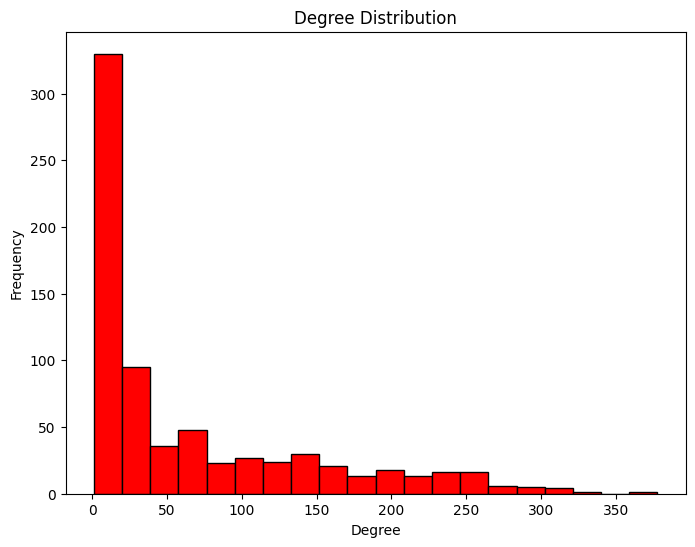

Hubs (airports with degree > 90th percentile): ['SEA', 'PDX', 'SFO', 'LAX', 'FLL', 'PHX', 'TUS', 'DFW', 'SLC', 'ABQ', 'LAS', 'ICT', 'OKC', 'SAN', 'OAK', 'IAH', 'ELP', 'TUL', 'OMA', 'AUS', 'COS', 'MSN', 'RFD', 'MKE', 'DSM', 'LIT', 'SHV', 'MCI', 'SAT', 'MSP', 'ORD', 'STL', 'BNA', 'MEM', 'IND', 'LRD', 'CLE', 'DTW', 'DAY', 'CVG', 'CMH', 'FWA', 'HOU', 'TOL', 'PIT', 'BOS', 'ATL', 'MDW', 'PHL', 'GSO', 'BUF', 'EWR', 'CLT', 'JFK', 'GRR', 'YIP', 'LGA', 'LEX', 'BHM', 'MCO', 'IAD', 'MSY', 'RDU', 'GSP', 'BDL', 'CAE', 'BWI', 'TYS', 'HSV', 'MIA', 'TPA', 'DAL', 'JAX']
The graph is sparse.


In [35]:
analyze_graph_features(flight_network)

## 1.2 Write a function <strong> summarize_graph_features(flight_network) </strong>

In [36]:
def summarize_graph_features(flight_network):
    # Summary dictionary to collect data
    summary = {}

    # 1. Number of nodes and edges
    num_nodes = flight_network.number_of_nodes()
    num_edges = flight_network.number_of_edges()
    summary['Number of nodes'] = num_nodes
    summary['Number of edges'] = num_edges

    # 2. Graph density
    density = (2 * num_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
    summary['Graph density'] = density

    # 3. Degree distribution
    degrees = dict(flight_network.degree())  # Degree distribution

    # Plot histogram for degree distribution
    plt.figure(figsize=(8, 6))
    plt.hist(degrees.values(), bins=20, color='skyblue', edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # 4. Identify hubs (airports with degree higher than the 90th percentile)
    degree_values = list(degrees.values())
    degree_90th_percentile = np.percentile(degree_values, 90)
    hubs = [(node, degree) for node, degree in degrees.items() if degree > degree_90th_percentile]
    hubs_df = pd.DataFrame(hubs, columns=['Airport', 'Degree']).sort_values(by='Degree', ascending=False)

    summary['Hubs'] = hubs_df

    # Print summary report
    print("\n--- Graph Summary Report ---")
    for key, value in summary.items():
        if key == 'Hubs':
            print(f"\n{key}:")
            print(value.to_string(index=False))
        else:
            print(f"{key}: {value}")

    return summary


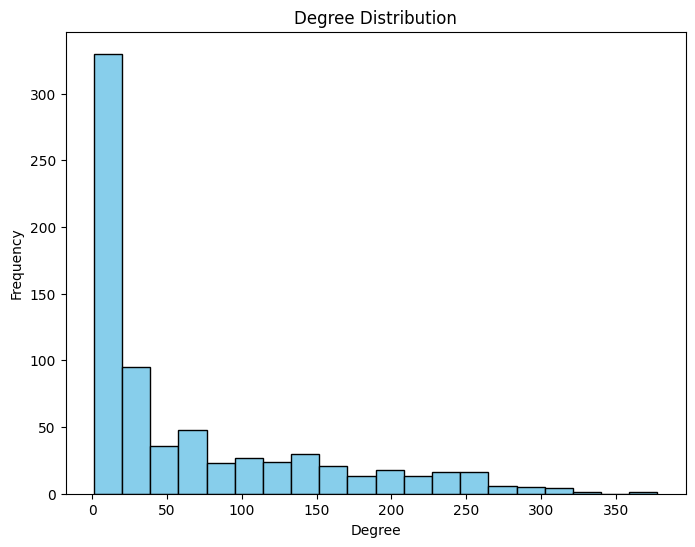


--- Graph Summary Report ---
Number of nodes: 727
Number of edges: 23260
Graph density: 0.08813911277335061

Hubs:
Airport  Degree
    YIP     378
    MSP     323
    MCI     319
    MEM     317
    ATL     308
    STL     304
    MIA     299
    ORD     299
    DFW     297
    IND     296
    OKC     290
    PHX     281
    SHV     280
    IAD     276
    DTW     272
    SLC     266
    LAS     266
    MKE     264
    IAH     264
    BWI     263
    LAX     262
    CLE     260
    ELP     259
    JFK     255
    TUS     255
    LIT     254
    EWR     252
    BNA     252
    CVG     252
    MDW     251
    PHL     250
    PIT     248
    RFD     247
    CLT     244
    LRD     244
    BOS     244
    SAT     243
    ICT     243
    MCO     241
    DAY     240
    RDU     239
    CMH     238
    SEA     235
    DAL     234
    MSY     234
    TUL     233
    SFO     230
    TYS     230
    OMA     229
    FLL     226
    BUF     225
    ABQ     223
    AUS     220
    OAK     219
    

{'Number of nodes': 727,
 'Number of edges': 23260,
 'Graph density': 0.08813911277335061,
 'Hubs':    Airport  Degree
 55     YIP     378
 29     MSP     323
 27     MCI     319
 33     MEM     317
 46     ATL     308
 ..     ...     ...
 21     MSN     200
 56     LGA     199
 49     GSO     198
 72     JAX     198
 68     HSV     197
 
 [73 rows x 2 columns]}

In [37]:
summarize_graph_features(flight_network)

## 1.3 Deeper analysis of the dataset

Compute total passenger flow between origin and destination cities.

In [38]:
def compute_passenger_flow(data):
    # Compute total passengers for each route
    passenger_flow = data.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
    passenger_flow = passenger_flow.rename(columns={'Passengers': 'Total_Passengers'})
    return passenger_flow

In [39]:
def visualize_busiest_routes(passenger_flow):
    # Identify top 10 busiest routes
    busiest_routes = passenger_flow.sort_values(by='Total_Passengers', ascending=False).head(10)

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.barh(
        busiest_routes.apply(lambda x: f"{x['Origin_airport']} → {x['Destination_airport']}", axis=1),
        busiest_routes['Total_Passengers'],
        color='skyblue'
    )
    plt.xlabel('Total Passengers')
    plt.ylabel('Route')
    plt.title('Top 10 Busiest Routes by Passenger Traffic')
    plt.gca().invert_yaxis()
    plt.show()

    return busiest_routes

In [40]:
def analyze_route_utilization(data):
    # Compute average passengers per flight
    data['Avg_Passengers_Per_Flight'] = data['Passengers'] / data['Flights']

    # Compute seat utilization for each route
    data['Seat_Utilization'] = (data['Passengers'] / data['Seats']) * 100

    # Classify routes as under-utilized or over-utilized
    data['Utilization_Class'] = data['Seat_Utilization'].apply(
        lambda x: 'Under-utilized' if x < 70 else 'Over-utilized'
    )

    return data[['Origin_airport', 'Destination_airport', 'Avg_Passengers_Per_Flight', 'Seat_Utilization', 'Utilization_Class']]

In [50]:
import folium

def create_flight_network_map(data):
    """
    Creates an interactive map visualizing the flight network.
    
    Parameters:
        data (pd.DataFrame): DataFrame with columns:
            'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long'.
    
    Returns:
        folium.Map: Interactive map showing flight network.
    """
    # Initialize the map at a central point
    flight_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)  # Center of the US

    # Iterate through the dataset and plot each flight route
    for _, row in data.iterrows():
        # Extract origin and destination coordinates
        origin_coords = (row['Org_airport_lat'], row['Org_airport_long'])
        dest_coords = (row['Dest_airport_lat'], row['Dest_airport_long'])
        
        # Add a line for the flight route
        folium.PolyLine(
            locations=[origin_coords, dest_coords],
            color='blue',
            weight=2,
            opacity=0.6
        ).add_to(flight_map)
    
    # Add markers for origin and destination airports
        folium.Marker(
            location=origin_coords,
            popup=f"Origin: {row['Origin_airport']}",
            icon=folium.Icon(color='green', icon='plane')
        ).add_to(flight_map)

        folium.Marker(
            location=dest_coords,
            popup=f"Destination: {row['Destination_airport']}",
            icon=folium.Icon(color='red', icon='plane')
        ).add_to(flight_map)
    
    return flight_map


In [48]:
# Compute passenger flow
passenger_flow = compute_passenger_flow(data)
passenger_flow

,Origin_airport,Destination_airport,Total_Passengers
0,1B1,BDL,1
1,ABE,ABE,2524
2,ABE,ACT,0
3,ABE,ACY,73
4,ABE,ADS,0
...,...,...,...
36714,YUM,YUM,0
36715,ZZV,MCI,0
36716,ZZV,PDK,0
36717,ZZV,SHV,0


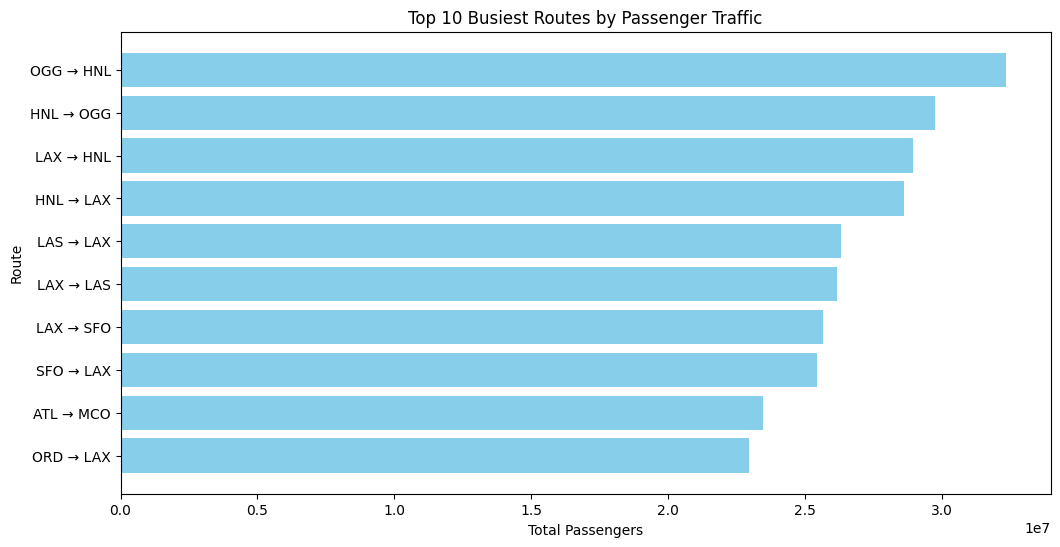

In [43]:
# Visualize busiest routes
busiest_routes = visualize_busiest_routes(passenger_flow)

In [46]:
# Analyze route utilization
utilization_analysis = analyze_route_utilization(data)
utilization_analysis

,Origin_airport,Destination_airport,Avg_Passengers_Per_Flight,Seat_Utilization,Utilization_Class
0,MHK,AMW,21.000000,70.000000,Over-utilized
1,EUG,RDM,1.863636,10.353535,Under-utilized
2,EUG,RDM,4.631579,25.730994,Under-utilized
3,EUG,RDM,2.750000,15.277778,Under-utilized
4,MFR,RDM,0.000000,0.000000,Under-utilized
...,...,...,...,...,...
3606798,STL,TBN,5.509804,28.998968,Under-utilized
3606799,STL,TBN,4.537037,23.879142,Under-utilized
3606800,STL,TBN,5.417910,28.515318,Under-utilized
3606801,CGI,TBN,2.000000,10.526316,Under-utilized
